# Pseudo Double Source Plane Lenses (PDSPL) Forecast
### Author: Paras Sharma

This notebook simulates pseudo double source plane lenses and mainly tries to answer the following questions:

Given the number of expected lenses to be of order 100'000, how near-identical are pairs of lenses to look like, such that they can be used as a defacto double source plane lenses?

1. Perform a forecast of lenses with SLSim
2. Assess how close nearest-pairs of lenses are look-alike and how much scatter they introduce in their estimated mass.
3. Perform a forecast how pseudo double source plane lenses can constrain cosmology pretending them to be double source plane lenses with increased measurement uncertainties. You can use hierArc to run the forecast.


In [ ]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.lens import Lens
from slsim.image_simulation import lens_image, rgb_image_from_image_list
from slsim.Util.param_util import gaussian_psf
# import standard python modules
import copy
import matplotlib.patches as mpatches
from itertools import combinations

%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane,
    # beta2theta_e_ratio,
)


## Generate population of sources and (potential) deflectors

In [52]:
# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# define a sky area
sky_area = Quantity(value=10, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo_true
)

# Initiate deflector population class.
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo_true,
    sky_area=sky_area,
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo_true,
    sky_area=sky_area,
    catalog_type="skypy",
)

# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo_true,
    sky_area=sky_area,
)

# make lensplot class for extracting rgb images
gg_plot = LensingPlots(gg_lens_pop, num_pix=100, coadd_years=10)

print(f"LensPop initialized. Potential deflectors: {gg_lens_pop.deflector_number} ; Potential sources: {gg_lens_pop.source_number}");

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


LensPop initialized. Potential deflectors: 3516648 ; Potential sources: 4748362


## Select Near-identical lenses using a criterion

In [ ]:
# kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
kwargs_lens_cut = {}
selected_lenses = gg_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut,
)
print(f"Number of selected lenses: {len(selected_lenses)}")

In [ ]:
# make pairs of deflector and source galaxies and find the measured ratios of the Einstein radius
lens_pairings = combinations(
    selected_lenses, 2
)  # all possible pairs of lenses
lens_pairings = list(lens_pairings)

pairing_parameters = {
    "lens_pairings": [],
    "z_D1": [],
    "z_D2": [],
    "z_S1": [],
    "z_S2": [],
    "theta_E1": [],
    "theta_E2": [],
    "theta_E_ratio": [],
    "theta_E1_virtual": [], # virtual Einstein radius of lens1 for source2
    "theta_E2_virtual": [], # virtual Einstein radius of lens2 for source1
    "theta_E1_by_theta_E2_virtual": [], # ratio of virtual Einstein radii
    "theta_E1_virtual_by_theta_E2": [], # ratio of virtual Einstein radii
    "sigma_v_D1": [], # velocity dispersion of deflector 1
    "sigma_v_D2": [], # velocity dispersion of deflector 2
    "beta_DSPL_D1": [], # beta double source plane i.e., ratio of distances, assuming D1
    "beta_DSPL_D2": [], # beta double source plane i.e., ratio of distances, assuming D2
    "delta_z_D": [], # difference in redshift of deflector 1 and 2
    "delta_sigma_v_D": [], # difference in velocity dispersions
    "abs_delta_z_D": [], # absolute difference in redshift of deflector 1 and 2
    "abs_delta_sigma_v_D": [], # absolute difference in velocity dispersions
}

for lens_pair in lens_pairings:
    lens1 = lens_pair[0]
    lens2 = lens_pair[1]

    source1 = lens1.source(index = 0)
    source2 = lens2.source(index = 0)

    deflector1 = lens1.deflector
    deflector2 = lens2.deflector

    # get the deflector and source redshifts
    z_D1 = lens1.deflector_redshift
    z_D2 = lens2.deflector_redshift
    z_S1 = source1.redshift
    z_S2 = source2.redshift

    # get the Einstein radii
    theta_E1 = lens1._einstein_radius(source1)
    theta_E2 = lens2._einstein_radius(source2)

    # get the velocity dispersions
    sigma_v_D1 = deflector1.velocity_dispersion()
    sigma_v_D2 = deflector2.velocity_dispersion()

    # calculate the ratio of the Einstein radii
    theta_E_ratio = theta_E1 / theta_E2

    # calculate the virtual Einstein radii
    theta_E1_virtual = lens2._einstein_radius(source1) # virtual Einstein radius of lens2 for source1
    theta_E2_virtual = lens1._einstein_radius(source2) # virtual Einstein radius of lens1 for source2

    # calculate the ratio of the virtual Einstein radii
    theta_E1_by_theta_E2_virtual = theta_E1 / theta_E2_virtual
    theta_E1_virtual_by_theta_E2 = theta_E1_virtual / theta_E2

    # calculate the beta double source plane
    if z_D1 < np.min([z_S1, z_S2]) and z_D2 < np.min([z_S1, z_S2]):
        beta_DSPL_D1 = beta_double_source_plane(
            z_D1, z_S1, z_S2, cosmo_true
        )
        beta_DSPL_D2 = beta_double_source_plane(
            z_D2, z_S1, z_S2, cosmo_true
        )
    elif z_D1 < np.min([z_S1, z_S2]) and z_D2 > np.max([z_S1, z_S2]):
        beta_DSPL_D1 = beta_double_source_plane(
            z_D1, z_S1, z_S2, cosmo_true
        )
        beta_DSPL_D2 = np.nan
    elif z_D1 > np.max([z_S1, z_S2]) and z_D2 < np.min([z_S1, z_S2]):
        beta_DSPL_D1 = np.nan
        beta_DSPL_D2 = beta_double_source_plane(
            z_D2, z_S1, z_S2, cosmo_true
        )
    else:
        beta_DSPL_D1 = np.nan
        beta_DSPL_D2 = np.nan

    # calculate the difference in redshift and velocity dispersion
    delta_z_D = z_D1 - z_D2
    delta_sigma_v_D = sigma_v_D1 - sigma_v_D2
    abs_delta_z_D = np.abs(delta_z_D)
    abs_delta_sigma_v_D = np.abs(delta_sigma_v_D)

    # append the values to the pairing_parameters dictionary
    pairing_parameters["lens_pairings"].append(lens_pair)
    pairing_parameters["z_D1"].append(z_D1)
    pairing_parameters["z_D2"].append(z_D2)
    pairing_parameters["z_S1"].append(z_S1)
    pairing_parameters["z_S2"].append(z_S2)
    pairing_parameters["theta_E1"].append(theta_E1)
    pairing_parameters["theta_E2"].append(theta_E2)
    pairing_parameters["theta_E_ratio"].append(theta_E_ratio)
    pairing_parameters["theta_E1_virtual"].append(theta_E1_virtual)
    pairing_parameters["theta_E2_virtual"].append(theta_E2_virtual)
    pairing_parameters["theta_E1_by_theta_E2_virtual"].append(
        theta_E1_by_theta_E2_virtual
    )
    pairing_parameters["theta_E1_virtual_by_theta_E2"].append(
        theta_E1_virtual_by_theta_E2
    )
    pairing_parameters["sigma_v_D1"].append(sigma_v_D1)
    pairing_parameters["sigma_v_D2"].append(sigma_v_D2)
    pairing_parameters["beta_DSPL_D1"].append(beta_DSPL_D1)
    pairing_parameters["beta_DSPL_D2"].append(beta_DSPL_D2)
    pairing_parameters["delta_z_D"].append(delta_z_D)
    pairing_parameters["delta_sigma_v_D"].append(delta_sigma_v_D)
    pairing_parameters["abs_delta_z_D"].append(abs_delta_z_D)
    pairing_parameters["abs_delta_sigma_v_D"].append(abs_delta_sigma_v_D)
# convert the pairing_parameters dictionary to a numpy array
pairing_parameters = {
    key: np.array(value) for key, value in pairing_parameters.items()
}

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_2855/3534211522.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  theta_E1_by_theta_E2_virtual = theta_E1 / theta_E2_virtual


Text(0.5, 0.95, 'Filtered Pairing Parameters (Delta z_D < 0.01, Delta sigma_v_D < 10)')

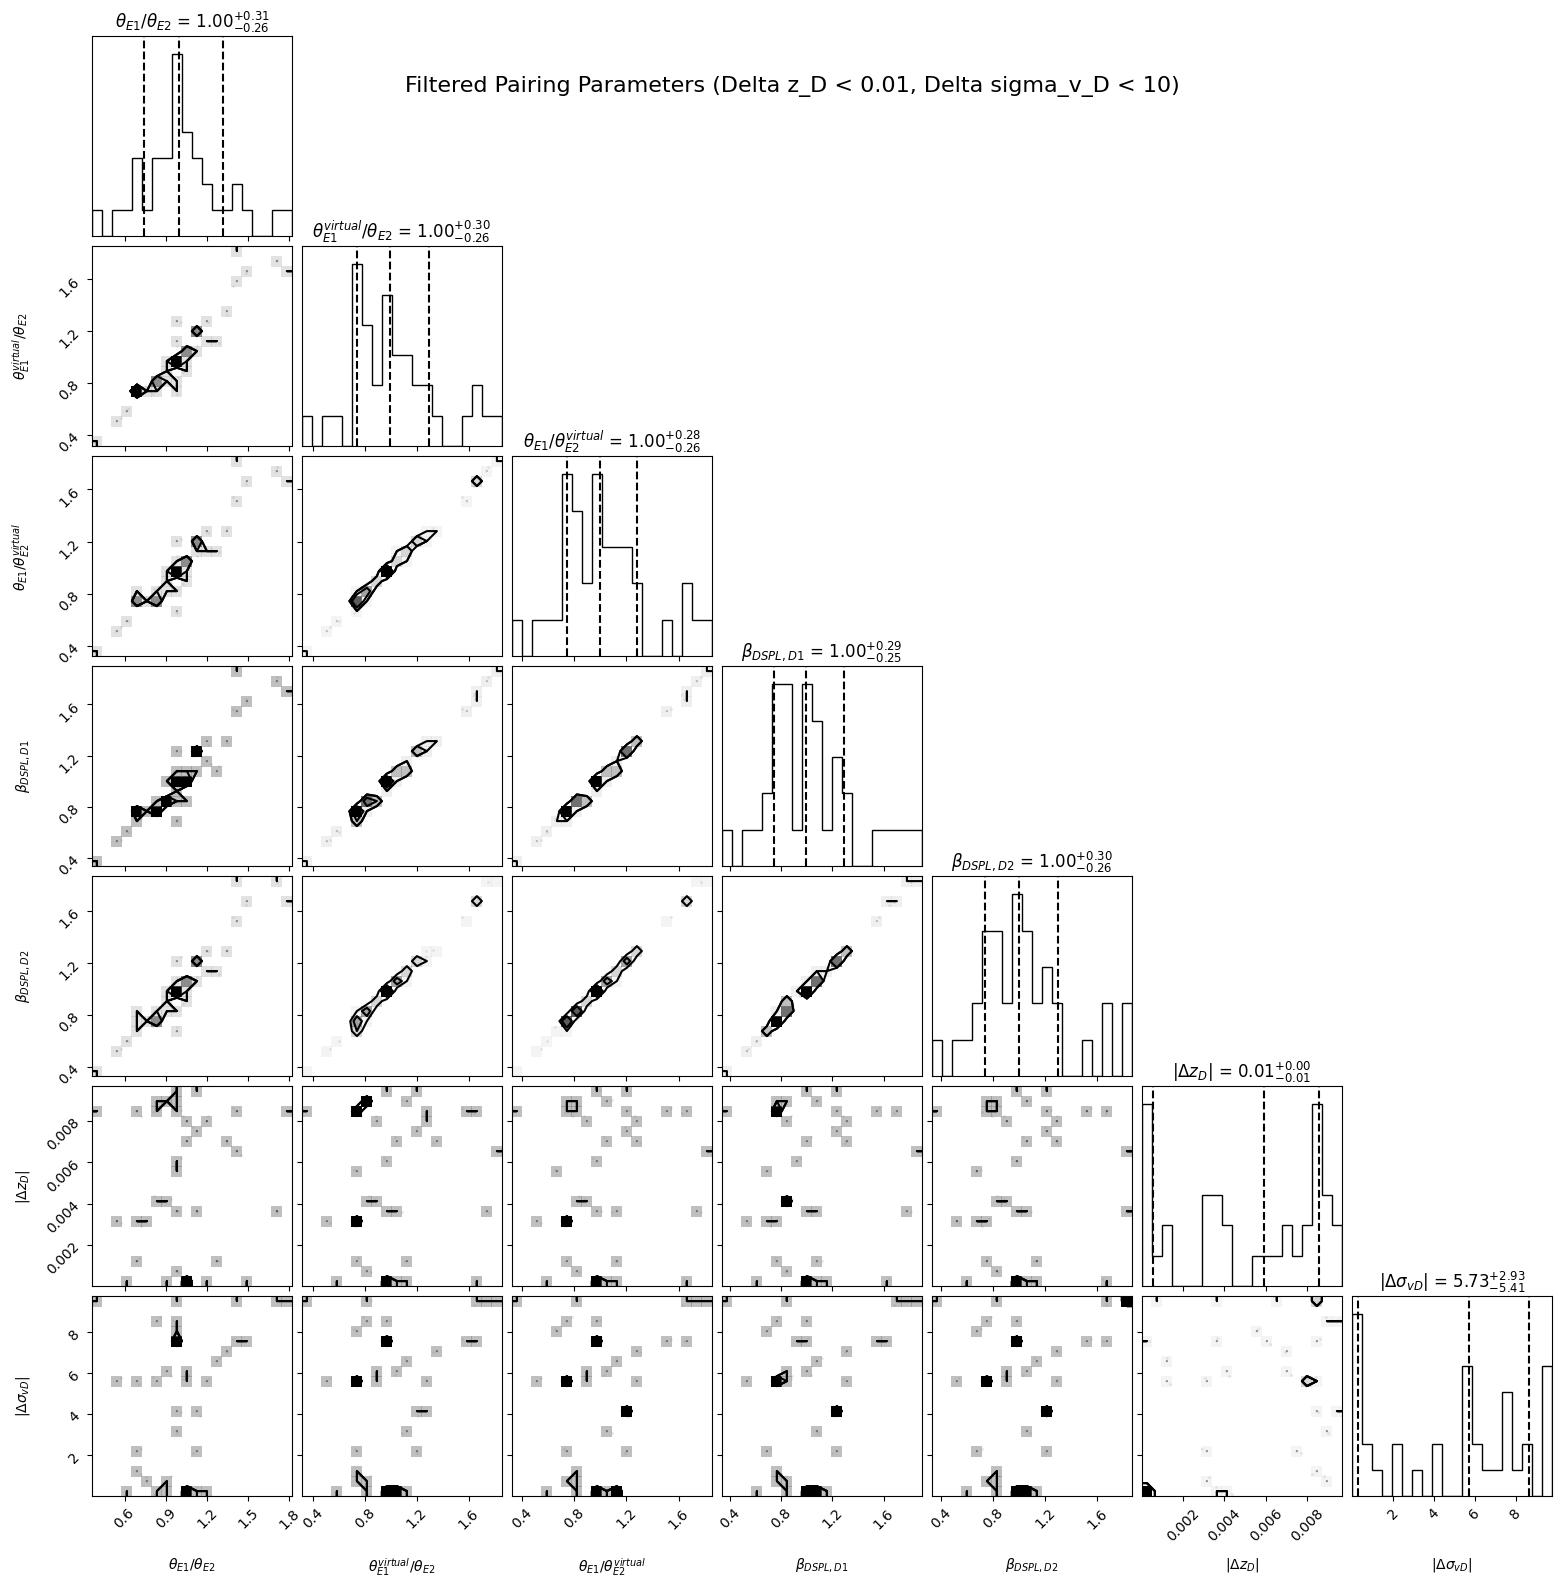

In [ ]:
# limit the pairs to those with small delta_z_D and delta_sigma_v_D
delta_z_D_limit = 0.01
delta_sigma_v_D_limit = 10
mask = (
    (pairing_parameters["abs_delta_z_D"] < delta_z_D_limit)
    & (pairing_parameters["abs_delta_sigma_v_D"] < delta_sigma_v_D_limit)
)
filtered_pairing_parameters = {
    key: value[mask] for key, value in pairing_parameters.items()
}

# this time only plot the filtered parameters
keys = [
    "theta_E_ratio",
    "theta_E1_virtual_by_theta_E2",
    "theta_E1_by_theta_E2_virtual",
    "beta_DSPL_D1", "beta_DSPL_D2",
    "abs_delta_z_D", "abs_delta_sigma_v_D",
]

latex_labels = {
    "theta_E_ratio": r"$\theta_{E1}/\theta_{E2}$",
    "theta_E1_virtual_by_theta_E2": r"$\theta_{E1}^{virtual}/\theta_{E2}$",
    "theta_E1_by_theta_E2_virtual": r"$\theta_{E1}/\theta_{E2}^{virtual}$",
    "beta_DSPL_D1": r"$\beta_{DSPL, D1}$",
    "beta_DSPL_D2": r"$\beta_{DSPL, D2}$",
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
}

# Stack into an (n_samples, n_keys) array:
data = np.column_stack([filtered_pairing_parameters[k] for k in keys])

# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
);
fig.suptitle(
    f"Filtered Pairing Parameters (Delta z_D < {delta_z_D_limit}, Delta sigma_v_D < {delta_sigma_v_D_limit})",
    fontsize=16,
    y=0.95,
)

## Likelihood function

$$ \mathcal{L} = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left(-\frac{(x_i - \mu_i))^2}{2\sigma_i^2}\right) $$

where $\theta$ is the parameter of interest, $x_i$ is the observed data, $\mu_i$ is the expected value, and $\sigma_i$ is the standard deviation of the measurement error.

$$x_i = \frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}$$

where $\tilde{\theta}_{E1}$ and $\tilde{\theta}_{E2}$ are measured Einstein radii of the two lenses with deflectors at nearly identical redshifts $z_d$ and sources at $z_1$ and $z_2$.

$$\mu_i = \frac{\theta_{E1}}{\theta_{E2}}\left[\gamma_{pl}, \lambda_{MST}, \beta(z_d, z_1, z_2, \Omega_m, w)\right]$$

where $\gamma_{pl}$ is the power-law slope of the mass profile, $\lambda_{MST}$ is the mass-sheet transformation parameter, and $\beta(z_d, z_1, z_2)$ is the DSPL parameter from distances ratios.

$$\sigma_i^2 = \sigma^2\left(\frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}\right)+ \sigma_{scatter}^2\left(\frac{{\theta}_{E1}}{{\theta}_{E2}}\right)$$

$$\sigma_{scatter}^2\left(\frac{{\theta}_{E1}}{{\theta}_{E2}}\right) = $$

For a power-law mass profile, the Einstein radius is given by (https://ned.ipac.caltech.edu/level5/Sept14/Courteau/Courteau7.html):
$$\theta_E(z_s)
=\Biggl[
  K(\gamma_{pl})\,
  \frac{\sigma_{\rm ap}^2}{c^2}\;
  \frac{D_{\rm ls}(z_{\rm l},\,z_s)}{D_{\rm s}(z_s)}
\Biggr]^{\!1/(\gamma_{pl}-1)}
$$

$$
K(\gamma_{pl})
=\frac{(3-\gamma_{pl})}{2\,\sqrt\pi}\,
\frac{\Gamma\!\bigl(\tfrac{\gamma_{pl}}{2}\bigr)}
     {\Gamma\!\bigl(\tfrac{\gamma_{pl}-1}{2}\bigr)}
$$

and the corresponding beta is 
$$
\beta_{\gamma_{pl}}
=\frac{\theta_E(z_{s2})}{\theta_E(z_{s1})}
=\left[
  \frac{\,D_{\rm ls}(z_{\rm l},\,z_{s2})/D_{\rm s}(z_{s2})\,}
       {\,D_{\rm ls}(z_{\rm l},\,z_{s1})/D_{\rm s}(z_{s1})\,}
\right]^{\!1/(\gamma_{pl}-1)}
$$

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [ ]:
# =====================================
# Settings for pupulation of DSP
# =====================================

# number of double source plane lenses
num_dspl = len(filtered_pairing_parameters["lens_pairings"])

sigma_beta = 0.01  # relative precision on measured Einstein radius ratio
gamma_pl_mean = 2.05
gamma_pl_sigma = 0.05

lambda_mst_mean = 1
lambda_mst_sigma = 0.05


def draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma, index_pairing):
    """
    draw the likelihood object of a double source plane lens
    """
    # z_lens = np.random.uniform(low=0.2, high=0.5)
    # z_source1 = np.random.uniform(low=z_lens + 0.2, high=1.5)
    # z_source2 = np.random.uniform(low=z_source1, high=3)

    # pick a random lens from the filtered pairing parameters
    z_lens = filtered_pairing_parameters["z_D1"][index_pairing] + filtered_pairing_parameters["delta_z_D"][index_pairing]
    z_lens /= 2
    z_source1 = filtered_pairing_parameters["z_S1"][index_pairing]
    z_source2 = filtered_pairing_parameters["z_S2"][index_pairing]

    # beta = beta_double_source_plane(z_lens, z_source1, z_source2, cosmo_true)
    # TODO: translate to measured Einstein radius ratio
    # lambda_mst = np.random.normal(lambda_mst_mean, lambda_mst_sigma)
    # gamma_pl = np.random.normal(gamma_pl_mean, gamma_pl_sigma)
    # beta_transformed = beta2theta_e_ratio(
    #     beta_dsp=beta, gamma_pl=gamma_pl, lambda_mst=lambda_mst
    # )
    # beta_measured = beta_transformed + np.random.normal(
    #     loc=0, scale=sigma_beta * beta_transformed
    # )
    beta_measured = filtered_pairing_parameters["theta_E_ratio"][index_pairing]
    # sigma_beta = 

    kwargs_likelihood = {
        "z_lens": z_lens,
        "z_source": z_source1,
        "z_source2": z_source2,
        "beta_dspl": beta_measured,
        "sigma_beta_dspl": sigma_beta * beta_measured,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood


kwargs_dspl_list = []

for i in range(num_dspl):
    kwargs_dspl_list.append(
        draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma, i)
    )

## hierArc sampling settings

In [ ]:
# sampling settings
n_walkers = 100
n_run = 200
n_burn = 200

cosmology = "FwCDM"

# TODO: num distribution draws

kwargs_mean_start = {
    "kwargs_cosmo": {"h0": 70, "om": 0.3, "w": -1},
    "kwargs_lens": {
        "lambda_mst": lambda_mst_mean,
        "lambda_mst_sigma": lambda_mst_sigma,
        "gamma_pl_mean": gamma_pl_mean,
        "gamma_pl_sigma": gamma_pl_sigma,
    },
}

kwargs_sigma_start = {
    "kwargs_cosmo": {"h0": 10, "om": 0.05, "w": 0.2},
    "kwargs_lens": {
        "lambda_mst": 0.1,
        "lambda_mst_sigma": 0.01,
        "gamma_pl_mean": 0.1,
        "gamma_pl_sigma": 0.01,
    },
}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w": -2},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w": 0},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},
    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5},
    "kwargs_fixed_lens": {
        "gamma_pl_sigma": gamma_pl_sigma,
        "lambda_mst_sigma": lambda_mst_sigma,
    },
}


# TODO: add gamma_pl population sampling
# TODO: add lambda_mst_sigma sampling

# joint options for hierArc sampling


kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "GAUSSIAN",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}


kwargs_sampler = {
    "custom_prior": None,
    "interpolate_cosmo": False,
    "num_redshift_interp": 100,
    "cosmo_fixed": None,
}

In [ ]:
mcmc_sampler = MCMCSampler(
    kwargs_dspl_list,
    cosmology=cosmology,
    kwargs_model=kwargs_model,
    kwargs_bounds=kwargs_bounds,
    **kwargs_sampler
)

likelihood = mcmc_sampler.chain
param = mcmc_sampler.param

kwargs_test = {
    "kwargs_cosmo": {"h0": 70, "om": 0.3, "w": -1},
    "kwargs_lens": {
        "lambda_mst": lambda_mst_mean,
        "lambda_mst_sigma": lambda_mst_sigma,
        "gamma_pl_mean": gamma_pl_mean + 0.0,
        "gamma_pl_sigma": gamma_pl_sigma,
    },
}

args = param.kwargs2args(**kwargs_test)

%timeit likelihood.likelihood(args)

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/lens_sample_likelihood.py:71: RuntimeWarning: overflow encountered in scalar add
  log_likelihood += lens.lens_log_likelihood(


16.4 ms ± 236 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%load_ext line_profiler

# %lprun -f likelihood.likelihood likelihood.likelihood(args)  # first level

from hierarc.Likelihood.lens_sample_likelihood import LensSampleLikelihood

# %lprun -f LensSampleLikelihood.log_likelihood likelihood.likelihood(args)  # second level


from hierarc.Likelihood.hierarchy_likelihood import LensLikelihood

# %lprun -f LensLikelihood.lens_log_likelihood likelihood.likelihood(args)  # third level

# %lprun -f LensLikelihood.hyper_param_likelihood likelihood.likelihood(args)  # 4th level

%lprun -f LensLikelihood.log_likelihood_single likelihood.likelihood(args)  # 5th level

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/lens_sample_likelihood.py:71: RuntimeWarning: overflow encountered in scalar add
  log_likelihood += lens.lens_log_likelihood(


Timer unit: 1e-09 s

Total time: 0.031138 s
File: /Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/hierarchy_likelihood.py
Function: log_likelihood_single at line 330

Line #      Hits         Time  Per Hit   % Time  Line Contents
   330                                               def log_likelihood_single(
   331                                                   self,
   332                                                   ddt,
   333                                                   dd,
   334                                                   delta_lum_dist,
   335                                                   beta_dsp,
   336                                                   kwargs_lens,
   337                                                   kwargs_kin,
   338                                                   kwargs_source,
   339                 

In [ ]:
mcmc_samples, log_prob = mcmc_sampler.mcmc_emcee(
    n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start
)

  0%|          | 0/400 [00:00<?, ?it/s]/opt/miniconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/400 [00:03<10:29,  1.58s/it]/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/hierarchy_likelihood.py:328: RuntimeWarning: divide by zero encountered in log
  return np.log(likelihood / self._num_distribution_draws)
100%|██████████| 400/400 [08:18<00:00,  1.25s/it]


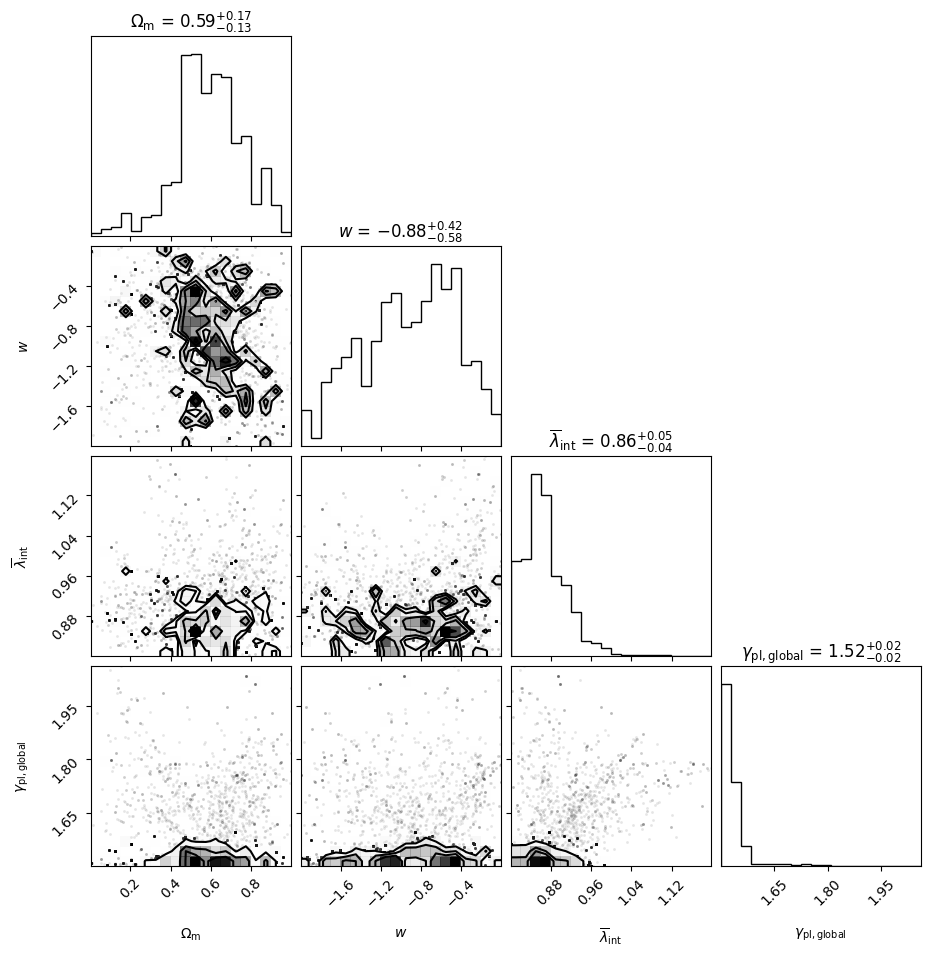

In [ ]:
corner.corner(
    mcmc_samples, show_titles=True, labels=mcmc_sampler.param_names(latex_style=True)
)
# plt.savefig("dsp_mst_gamma.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Further Analysis

Let's take a look at the scatter between $\frac{\theta_{E1}}{\theta_{E2}}$ and $\frac{\theta_{E1}^{virtual}}{\theta_{E2}}$

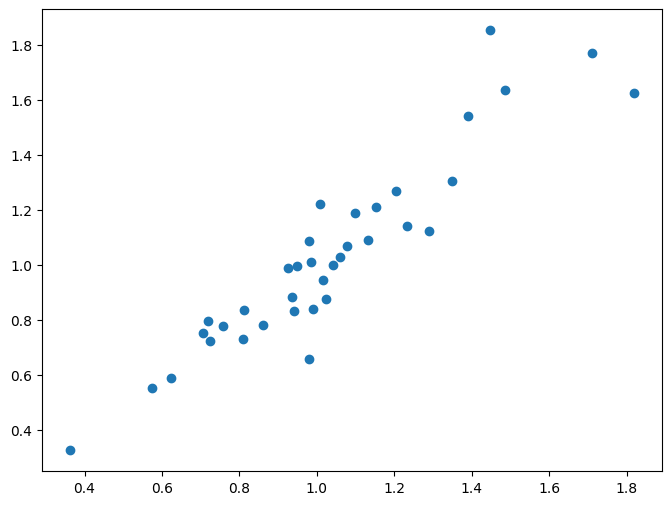

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(filtered_pairing_parameters["theta_E_ratio"], filtered_pairing_parameters["theta_E1_by_theta_E2_virtual"], "o")